## Show CL spread histories to see how large contangos and backwardations have been.

## IF YOU WANT TO SEE WARNINGS, COMMENT THIS OUT

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import zipfile
import glob
import pandas as pd
import numpy as np

from argparse import ArgumentParser
from argparse import RawDescriptionHelpFormatter
import sys
import os
if  not './' in sys.path:
    sys.path.append('./')
if  not '../' in sys.path:
    sys.path.append('../')

from barchartacs import build_db
from barchartacs import db_info
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.tools as tls
from plotly.graph_objs.layout import Font,Margin
from IPython import display

import datetime
import io
from tqdm import tqdm,tqdm_notebook
from barchartacs import pg_pandas as pg
import mibian
import py_vollib
import importlib
from py_vollib import black
from py_vollib.black import implied_volatility
import ipdb
import traceback
import pandas_datareader.data as pdr
from scipy.stats import norm

from ipysheet import from_dataframe,to_dataframe


### important global variables

In [3]:

DEBUG_IT=False
opttab = 'sec_schema.options_table'
futtab = 'sec_schema.underlying_table'
USE_PYVOL = True

# df_expiry_dates_additions = pd.read_csv('df_expiry_dates_additions.csv')
df_expiry_dates_additions = pd.read_csv('live_option_expirations.csv')


#### get all contracts in the options database

In [4]:
pga = db_info.get_db_info()
print(f"futtab max date: {pga.get_sql(f'select max(settle_date) from {futtab}')}")
print(f"opttab max date: {pga.get_sql(f'select max(settle_date) from {opttab}')}")


  sec_db
futtab max date:         max
0  20200408
opttab max date:         max
0  20200408


In [5]:
def plotly_plot(df_in,x_column,plot_title=None,
                y_left_label=None,y_right_label=None,
                bar_plot=False,width=800,height=400,
                number_of_ticks_display=20,
                yaxis2_cols=None,
                x_value_labels=None):
    ya2c = [] if yaxis2_cols is None else yaxis2_cols
    ycols = [c for c in df_in.columns.values if c != x_column]
    # create tdvals, which will have x axis labels
    td = list(df_in[x_column]) 
    nt = len(df_in)-1 if number_of_ticks_display > len(df_in) else number_of_ticks_display
    spacing = len(td)//nt
    tdvals = td[::spacing]
    tdtext = tdvals
    if x_value_labels is not None:
        tdtext = [x_value_labels[i] for i in tdvals]
    
    # create data for graph
    data = []
    # iterate through all ycols to append to data that gets passed to go.Figure
    for ycol in ycols:
        if bar_plot:
            b = go.Bar(x=td,y=df_in[ycol],name=ycol,yaxis='y' if ycol not in ya2c else 'y2')
        else:
            b = go.Scatter(x=td,y=df_in[ycol],name=ycol,yaxis='y' if ycol not in ya2c else 'y2')
        data.append(b)

    # create a layout
    layout = go.Layout(
        title=plot_title,
        xaxis=dict(
            ticktext=tdtext,
            tickvals=tdvals,
            tickangle=45,
            type='category'),
        yaxis=dict(
            title='y main' if y_left_label is None else y_left_label
        ),
        yaxis2=dict(
            title='y alt' if y_right_label is None else y_right_label,
            overlaying='y',
            side='right'),
        autosize=False,
        width=width,
        height=height,
        margin=Margin(
            l=50,
            r=50,
            b=100,
#             t=100,
            pad=4
        )        
    )

    fig = go.Figure(data=data,layout=layout)
    fig.update_layout(
        title={
            'text': plot_title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    return fig

def plotly_shaded_rectangles(beg_end_date_tuple_list,fig):
    ld_shapes = []
    for beg_end_date_tuple in beg_end_date_tuple_list:
        ld_beg = beg_end_date_tuple[0]
        ld_end = beg_end_date_tuple[1]
        ld_shape = dict(
            type="rect",
            # x-reference is assigned to the x-values
            xref="x",
            # y-reference is assigned to the plot paper [0,1]
            yref="paper",
            x0=ld_beg[i],
            y0=0,
            x1=ld_end[i],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
        ld_shapes.append(ld_shape)

    fig.update_layout(shapes=ld_shapes)
    return fig

### Larges CL contangos

In [6]:
sql_all_cl = f"""
select settle_date,symbol,close from {futtab} where substring(symbol,1,2)='CL'
"""
df_all_cl = pga.get_sql(sql_all_cl)

In [7]:
df_syms = pd.DataFrame({'symbol':df_all_cl.symbol.unique()})
df_syms['ssyym'] = df_syms.symbol.apply(lambda s:f'{s[0:2]}{s[-2:]}{s[2]}')
df_syms = df_syms.sort_values('ssyym')
allc_ordered = df_syms.symbol.values



### Create a DataFrame whose columns contain the closing values for successive contract months in CL
1. ```df_final`` contains columns in the form ```m1, m2, ...,m12```
2. Each column holds a closing price for that month


In [8]:
final_yyyymmdd = df_all_cl.settle_date.max()
df_final = None
beg_date = 20100101
# loop on all contracts in allc_ordered
for i in tqdm_notebook(range(len(allc_ordered))):
    if (i==0) or (df_final.settle_date.max()<final_yyyymmdd):
        # get 12 contracts at a time, starting with contract allc_ordered[i]
        current_12 = allc_ordered[i:i+12] 
        # get settle_data and close of allc_contract[i]
        df_m1 = df_all_cl[(df_all_cl.symbol==current_12[0]) & (df_all_cl.settle_date>beg_date)][['settle_date','close']]
        # rename close to 'm1' for month 1
        df_m1 = df_m1.rename(columns={'close':'m1'})
        df_m1.index = list(range(len(df_m1)))
        # now loop on next 11 contracts, and append a column to df_m1 for the close of those successive months
        for j in range(1,12):
            df_m_j = df_all_cl[(df_all_cl.symbol==current_12[j]) & (df_all_cl.settle_date>beg_date)][['settle_date','close']]
            df_m_j = df_m_j.rename(columns={'close':f'm{j+1}'})
            df_m_j.index = list(range(len(df_m_j)))
            df_m1 =  df_m1.merge(df_m_j,on='settle_date',how='inner')
        # now that you have 12 month columns
        if df_final is None:
            df_final = df_m1.copy()
        else:
            df_final = df_final.append(df_m1,ignore_index=True)
        beg_date = df_final.settle_date.max()


In [9]:
len(df_final)

2418

### Create a single DataFrame showing one-month spread values for each day in CL
1. ```df_final_spread``` contains columns in the form ```sm2_m1, sm3_m2, ..., sm12_m11, sm12-m1```
2. Each column holds a spread between month n and month n-1
3. The last column holds the spread between month 12 and month 1


In [10]:
df_final_spread = df_final[['settle_date']]
for i in range(2,13):
    mfront = f'm{i-1}'
    mback = f'm{i}'    
    df_final_spread[f's{mback}_{mfront}'] = df_final[mback] - df_final[mfront]
spread_cols = [c  for c in df_final_spread.columns.values if c != 'settle_date']
df_final_spread['sm12_m1'] = df_final_spread.apply(lambda r:sum([r[c] for c in spread_cols]),axis=1) 


2020-04-09 08:45:42,682 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


In [11]:
df_fs = df_final_spread[['settle_date','sm12_m1']]
df_fs.settle_date = df_fs.settle_date.apply(lambda v:f"{str(v)[0:4]}-{str(v)[4:6]}-{str(v)[6:8]}")
fig = plotly_plot(df_in=df_fs.iloc[-200:],x_column='settle_date',
                  plot_title='1 Year CL Spread',
                  y_left_label='Spread Price')
fig.update_yaxes(automargin=True)
iplot(fig)


-14.030000000000001 15.319999999999997


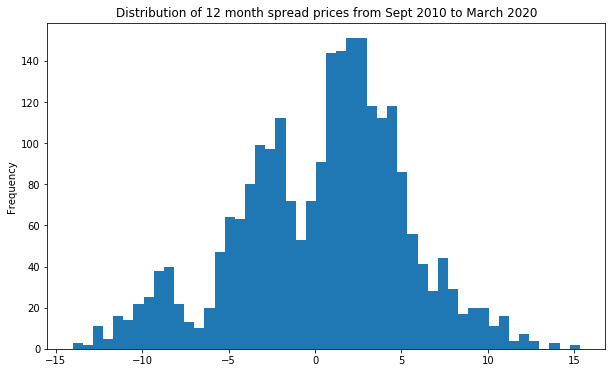

In [12]:
print(df_final_spread.sm12_m1.min(),df_final_spread.sm12_m1.max())
t = "Distribution of 12 month spread prices from Sept 2010 to March 2020"
df_final_spread.sm12_m1.plot(kind='hist',bins=50,figsize=(10,6),title=t)

In [13]:
df_biggest_containgos = df_final_spread.sort_values('sm12_m1',ascending=False).head(10)
df_biggest_containgos.index = list(range(len(df_biggest_containgos)))
df_recent_containgos = df_final_spread[df_final_spread.settle_date>=20200301].tail()
df_recent_containgos.index = list(range(len(df_recent_containgos)))
df_biggest_containgos.to_csv('temp_folder/df_biggest_containgos.csv',index=False)
df_recent_containgos.to_csv('temp_folder/df_recent_containgos.csv',index=False)


In [14]:
df_biggest_containgos

,settle_date,sm2_m1,sm3_m2,sm4_m3,sm5_m4,sm6_m5,sm7_m6,sm8_m7,sm9_m8,sm10_m9,sm11_m10,sm12_m11,sm12_m1
0,20200330,4.00,3.31,2.16,1.44,1.03,0.87,0.68,0.56,0.47,0.42,0.38,15.32
1,20200331,4.03,3.18,2.10,1.33,0.96,0.83,0.67,0.57,0.49,0.46,0.42,15.04
2,20110214,3.92,3.53,1.98,1.34,0.83,0.55,0.46,0.43,0.39,0.35,0.27,14.05
3,20200401,3.43,2.68,1.89,1.24,0.97,0.88,0.74,0.61,0.52,0.47,0.44,13.87
4,20200327,3.64,2.98,1.92,1.25,0.84,0.71,0.60,0.49,0.44,0.42,0.39,13.68
5,20110215,3.25,3.29,1.82,1.28,0.82,0.56,0.46,0.42,0.38,0.33,0.25,12.86
6,20110209,3.39,3.09,1.94,1.27,0.79,0.53,0.48,0.41,0.37,0.31,0.24,12.82
7,20110211,3.55,3.22,1.79,1.20,0.71,0.47,0.41,0.40,0.37,0.32,0.25,12.69
8,20110216,2.85,3.12,1.86,1.31,0.84,0.60,0.50,0.45,0.38,0.32,0.24,12.47
9,20200407,5.06,3.15,1.08,0.56,0.42,0.40,0.37,0.32,0.27,0.25,0.26,12.14


In [15]:
df_recent_containgos

,settle_date,sm2_m1,sm3_m2,sm4_m3,sm5_m4,sm6_m5,sm7_m6,sm8_m7,sm9_m8,sm10_m9,sm11_m10,sm12_m11,sm12_m1
0,20200402,2.73,1.87,0.99,0.59,0.50,0.54,0.51,0.44,0.39,0.37,0.35,9.28
1,20200403,2.56,1.43,0.67,0.37,0.25,0.28,0.26,0.21,0.22,0.23,0.24,6.72
2,20200406,3.90,2.06,0.89,0.50,0.34,0.31,0.28,0.21,0.22,0.25,0.25,9.21
3,20200407,5.06,3.15,1.08,0.56,0.42,0.40,0.37,0.32,0.27,0.25,0.26,12.14
4,20200408,5.08,2.75,0.73,0.35,0.30,0.32,0.32,0.28,0.23,0.22,0.22,10.80


In [16]:
sql_cl_one_day = f"""
select settle_date,symbol,close from {futtab} where settle_date = 20200323
and substring(symbol,1,2)='CL'
"""
pga.get_sql(sql_cl_one_day).iloc[:14]

,settle_date,symbol,close
0,20200323,CLZ99,23.78
1,20200323,CLK20,23.36
2,20200323,CLM20,25.48
3,20200323,CLN20,27.23
4,20200323,CLQ20,28.44
5,20200323,CLU20,29.39
6,20200323,CLV20,30.17
7,20200323,CLX20,30.88
8,20200323,CLZ20,31.50
9,20200323,CLF21,32.02
